In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/sisa

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 390 (delta 0), reused 0 (delta 0), pack-reused 359 (from 1)
Receiving objects: 100% (390/390), 293.45 MiB | 41.11 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Updating files: 100% (77/77), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/sisa


## Dependencies

In [2]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Init model
from models.effnetb0 import init_model_effnetb0

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cuda


## Parameters (arbitrary chosen)

In [5]:
BATCH_SIZE = 64

LEARNING_RATE = 0.001

EPOCHS = 3

SHARDS = 3

SLICES = 5

# SISA structure

## Get data transform

In [6]:
*_, transform = init_model_effnetb0()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 128MB/s] 


Done initializing model.
Model ID: 135288898776384, Optimizer ID: 135288898776480, Criterion ID: 135288898777632


## Load dataset

In [7]:
data_root = Path('/kaggle/input/animal-faces') # Only add if in kaggle env

In [8]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Create SISA structure

In [9]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES)

SISA structure saved to sisa_structure.json


In [10]:
sisa_structure_file = 'sisa_structure.json'

## Prepare DataLoaders from json file

In [11]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

# Train using SISA framework

## Models output path

In [12]:
save_models_metrics_dir = './sisa_models'

## Call train

In [13]:
import time
start_time = time.perf_counter()

sisa_train(
    dataloaders=dataloaders, 
    num_epochs=EPOCHS, 
    save_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    learning_rate=LEARNING_RATE,
    )

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Training shard: shard_0
Init model...
Done initializing model.
Model ID: 135288898874544, Optimizer ID: 135288898868064, Criterion ID: 135288898877472
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [1/3], Train Loss: 0.2502, Train Accuracy: 0.9237, Val Loss: 0.0574, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch [2/3], Train Loss: 0.0458, Train Accuracy: 0.9875, Val Loss: 0.0031, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch [3/3], Train Loss: 0.0501, Train Accuracy: 0.9852, Val Loss: 0.0576, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [1/3], Train Loss: 0.0478, Train Accuracy: 0.9863, Val Loss: 0.0337, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [2/3], Train Loss: 0.0245, Train Accuracy: 0.9897, Val Loss: 0.0193, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch [3/3], Train Loss: 0.0042, Train Accuracy: 1.0000, Val Loss: 0.0498, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [1/3], Train Loss: 0.0508, Train Accuracy: 0.9875, Val Loss: 0.1089, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch [2/3], Train Loss: 0.0360, Train Accuracy: 0.9954, Val Loss: 0.0013, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch [3/3], Train Loss: 0.0146, Train Accuracy: 0.9943, Val Loss: 0.0017, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch [1/3], Train Loss: 0.0707, Train Accuracy: 0.9852, Val Loss: 0.0221, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch [2/3], Train Loss: 0.0171, Train Accuracy: 0.9977, Val Loss: 0.0249, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [3/3], Train Loss: 0.0057, Train Accuracy: 0.9989, Val Loss: 0.0016, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [1/3], Train Loss: 0.0431, Train Accuracy: 0.9920, Val Loss: 0.1112, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch [2/3], Train Loss: 0.0204, Train Accuracy: 0.9932, Val Loss: 0.0467, Val Accuracy: 0.9794
Epoch 2: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [3/3], Train Loss: 0.0048, Train Accuracy: 0.9989, Val Loss: 0.0698, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_0_final_model.pth
Training shard: shard_1
Init model...
Done initializing model.
Model ID: 135288875484976, Optimizer ID: 135288898874592, Criterion ID: 135289588862112
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch [1/3], Train Loss: 0.2943, Train Accuracy: 0.8998, Val Loss: 0.0036, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [2/3], Train Loss: 0.0259, Train Accuracy: 0.9909, Val Loss: 0.0688, Val Accuracy: 0.9691


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [3/3], Train Loss: 0.0265, Train Accuracy: 0.9920, Val Loss: 0.0079, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch [1/3], Train Loss: 0.0504, Train Accuracy: 0.9829, Val Loss: 0.0081, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [2/3], Train Loss: 0.0422, Train Accuracy: 0.9886, Val Loss: 0.0523, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch [3/3], Train Loss: 0.0230, Train Accuracy: 0.9954, Val Loss: 0.0223, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch [1/3], Train Loss: 0.0291, Train Accuracy: 0.9909, Val Loss: 0.0149, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch [2/3], Train Loss: 0.0176, Train Accuracy: 0.9966, Val Loss: 0.0110, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [3/3], Train Loss: 0.0055, Train Accuracy: 0.9989, Val Loss: 0.0129, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [1/3], Train Loss: 0.0411, Train Accuracy: 0.9886, Val Loss: 0.0023, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Epoch [2/3], Train Loss: 0.0179, Train Accuracy: 0.9954, Val Loss: 0.0004, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [3/3], Train Loss: 0.0071, Train Accuracy: 0.9977, Val Loss: 0.0006, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch [1/3], Train Loss: 0.0216, Train Accuracy: 0.9920, Val Loss: 0.0115, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [2/3], Train Loss: 0.0257, Train Accuracy: 0.9898, Val Loss: 0.0427, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [3/3], Train Loss: 0.0192, Train Accuracy: 0.9943, Val Loss: 0.0296, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_1_final_model.pth
Training shard: shard_2
Init model...
Done initializing model.
Model ID: 135288898677600, Optimizer ID: 135288898680960, Criterion ID: 135288898677504
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch [1/3], Train Loss: 0.2671, Train Accuracy: 0.9055, Val Loss: 0.3720, Val Accuracy: 0.9588
Epoch 1: New best validation accuracy: 0.9588. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch [2/3], Train Loss: 0.0997, Train Accuracy: 0.9658, Val Loss: 0.1024, Val Accuracy: 0.9381


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Epoch [3/3], Train Loss: 0.0235, Train Accuracy: 0.9977, Val Loss: 0.0781, Val Accuracy: 0.9691
Epoch 3: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [1/3], Train Loss: 0.0628, Train Accuracy: 0.9841, Val Loss: 0.0021, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch [2/3], Train Loss: 0.0344, Train Accuracy: 0.9886, Val Loss: 0.0088, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch [3/3], Train Loss: 0.0184, Train Accuracy: 0.9943, Val Loss: 0.0127, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Epoch [1/3], Train Loss: 0.0378, Train Accuracy: 0.9886, Val Loss: 0.0087, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [2/3], Train Loss: 0.0164, Train Accuracy: 0.9966, Val Loss: 0.0383, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch [3/3], Train Loss: 0.0095, Train Accuracy: 0.9977, Val Loss: 0.0209, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch [1/3], Train Loss: 0.0418, Train Accuracy: 0.9886, Val Loss: 0.0019, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [2/3], Train Loss: 0.0123, Train Accuracy: 0.9966, Val Loss: 0.0075, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [3/3], Train Loss: 0.0089, Train Accuracy: 0.9989, Val Loss: 0.0139, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch [1/3], Train Loss: 0.0194, Train Accuracy: 0.9886, Val Loss: 0.0140, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch [2/3], Train Loss: 0.0323, Train Accuracy: 0.9921, Val Loss: 0.0078, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

Epoch [3/3], Train Loss: 0.0142, Train Accuracy: 0.9943, Val Loss: 0.0629, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_2_final_model.pth
Execution time: 445.223516 seconds


## Call test

In [14]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 135288898864896, Optimizer ID: 135288898866192, Criterion ID: 135288898865760
Loading and testing model: ./sisa_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Predictions and labels saved to ./sisa_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288875339200, Optimizer ID: 135288875336176, Criterion ID: 135288875341648
Loading and testing model: ./sisa_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Predictions and labels saved to ./sisa_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288875497984, Optimizer ID: 135288875489392, Criterion ID: 135288875495344
Loading and testing model: ./sisa_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]

Predictions and labels saved to ./sisa_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [17]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9987
  Precision: 0.9987
  Recall: 0.9987
  F1 Score: 0.9987
Shard shard_1 Metrics:
  Accuracy: 0.9847
  Precision: 0.9849
  Recall: 0.9847
  F1 Score: 0.9847
Shard shard_2 Metrics:
  Accuracy: 0.9867
  Precision: 0.9869
  Recall: 0.9867
  F1 Score: 0.9867

Aggregated Model Metrics:
  Accuracy: 0.9973
  Precision: 0.9973
  Recall: 0.9973
  F1 Score: 0.9973


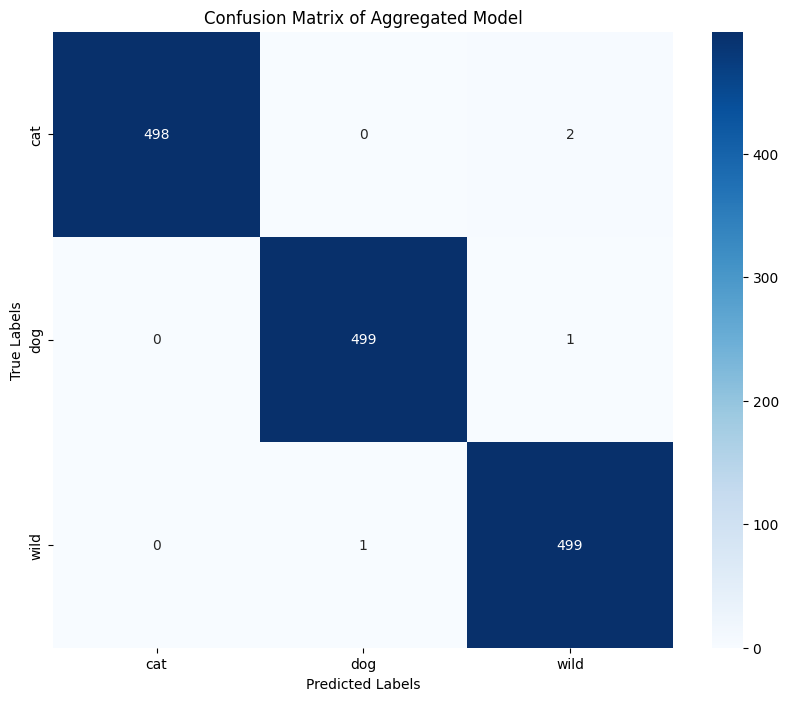

In [18]:
evaluate_aggregated_model(results, classes)

# SISA re-train

## Paths to data info

In [52]:
samples_to_delete = project_root/'experiments/animal_faces/naive/afhq_samples_to_unlearn_20per.json'
sisa_structure = 'sisa_structure.json'
updated_sisa_structure = 'updated_sisa_strucute.json'
deleted_samples = 'deleted_samples.json'

## Update sisa structure -> delete samples 

In [53]:
affected_shards = update_sisa_structure(samples_to_delete, sisa_structure, updated_sisa_structure,deleted_samples)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file

In [54]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

## Models output path

In [55]:
save_path = "./sisa_updated_models"

## Retrain the affected shards

In [56]:
import time
start_time = time.perf_counter()

retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_effnetb0, 
    learning_rate=LEARNING_RATE
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Retraining shard: shard_0
Init model...
Done initializing model.
Model ID: 135288741186384, Optimizer ID: 135288741186960, Criterion ID: 135288741186672
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [1/3], Train Loss: 0.3259, Train Accuracy: 0.8951, Val Loss: 0.1025, Val Accuracy: 0.9873
Epoch 1: New best validation accuracy: 0.9873. Model saved to ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch [2/3], Train Loss: 0.0791, Train Accuracy: 0.9748, Val Loss: 0.0578, Val Accuracy: 0.9747


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Epoch [3/3], Train Loss: 0.0269, Train Accuracy: 0.9902, Val Loss: 0.0407, Val Accuracy: 0.9873
Training complete for ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch [1/3], Train Loss: 0.0578, Train Accuracy: 0.9816, Val Loss: 0.0144, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch [2/3], Train Loss: 0.0681, Train Accuracy: 0.9760, Val Loss: 0.0288, Val Accuracy: 0.9872


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


Epoch [3/3], Train Loss: 0.0498, Train Accuracy: 0.9802, Val Loss: 0.0433, Val Accuracy: 0.9872
Training complete for ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [1/3], Train Loss: 0.1071, Train Accuracy: 0.9730, Val Loss: 0.0166, Val Accuracy: 0.9872
Epoch 1: New best validation accuracy: 0.9872. Model saved to ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch [2/3], Train Loss: 0.0237, Train Accuracy: 0.9929, Val Loss: 0.0038, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch [3/3], Train Loss: 0.0064, Train Accuracy: 0.9986, Val Loss: 0.0101, Val Accuracy: 0.9872
Training complete for ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Epoch [1/3], Train Loss: 0.0456, Train Accuracy: 0.9874, Val Loss: 0.0072, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch [2/3], Train Loss: 0.0304, Train Accuracy: 0.9874, Val Loss: 0.0158, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Epoch [3/3], Train Loss: 0.0170, Train Accuracy: 0.9972, Val Loss: 0.0186, Val Accuracy: 0.9873
Training complete for ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


Epoch [1/3], Train Loss: 0.0478, Train Accuracy: 0.9871, Val Loss: 0.0083, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Epoch [2/3], Train Loss: 0.0161, Train Accuracy: 0.9986, Val Loss: 0.0129, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Epoch [3/3], Train Loss: 0.0062, Train Accuracy: 0.9986, Val Loss: 0.0032, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_0 to ./sisa_updated_models/shard_0_final_model.pth
Retraining shard: shard_1
Init model...
Done initializing model.
Model ID: 135288853460592, Optimizer ID: 135288741187296, Criterion ID: 135288741187008
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch [1/3], Train Loss: 0.3116, Train Accuracy: 0.9024, Val Loss: 0.1726, Val Accuracy: 0.9610
Epoch 1: New best validation accuracy: 0.9610. Model saved to ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch [2/3], Train Loss: 0.0610, Train Accuracy: 0.9842, Val Loss: 0.0390, Val Accuracy: 0.9870
Epoch 2: New best validation accuracy: 0.9870. Model saved to ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


Epoch [3/3], Train Loss: 0.0206, Train Accuracy: 0.9928, Val Loss: 0.0526, Val Accuracy: 0.9740
Training complete for ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch [1/3], Train Loss: 0.0452, Train Accuracy: 0.9870, Val Loss: 0.0195, Val Accuracy: 0.9868
Epoch 1: New best validation accuracy: 0.9868. Model saved to ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Epoch [2/3], Train Loss: 0.0229, Train Accuracy: 0.9928, Val Loss: 0.0219, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Epoch [3/3], Train Loss: 0.0275, Train Accuracy: 0.9913, Val Loss: 0.0054, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Epoch [1/3], Train Loss: 0.0583, Train Accuracy: 0.9829, Val Loss: 0.0023, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Epoch [2/3], Train Loss: 0.0418, Train Accuracy: 0.9872, Val Loss: 0.0592, Val Accuracy: 0.9870


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch [3/3], Train Loss: 0.0157, Train Accuracy: 0.9957, Val Loss: 0.1535, Val Accuracy: 0.9740
Training complete for ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Epoch [1/3], Train Loss: 0.0312, Train Accuracy: 0.9872, Val Loss: 0.0042, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Epoch [2/3], Train Loss: 0.0350, Train Accuracy: 0.9915, Val Loss: 0.0018, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


Epoch [3/3], Train Loss: 0.0225, Train Accuracy: 0.9929, Val Loss: 0.0049, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


Epoch [1/3], Train Loss: 0.0535, Train Accuracy: 0.9886, Val Loss: 0.0016, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch [2/3], Train Loss: 0.0228, Train Accuracy: 0.9886, Val Loss: 0.0116, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


Epoch [3/3], Train Loss: 0.0140, Train Accuracy: 0.9971, Val Loss: 0.0036, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_1 to ./sisa_updated_models/shard_1_final_model.pth
Retraining shard: shard_2
Init model...
Done initializing model.
Model ID: 135288869168432, Optimizer ID: 135288886999600, Criterion ID: 135288886993888
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch [1/3], Train Loss: 0.3489, Train Accuracy: 0.8982, Val Loss: 0.0067, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Epoch [2/3], Train Loss: 0.0500, Train Accuracy: 0.9833, Val Loss: 0.0374, Val Accuracy: 0.9620


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Epoch [3/3], Train Loss: 0.0188, Train Accuracy: 0.9972, Val Loss: 0.0361, Val Accuracy: 0.9873
Training complete for ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


Epoch [1/3], Train Loss: 0.0581, Train Accuracy: 0.9831, Val Loss: 0.1279, Val Accuracy: 0.9615
Epoch 1: New best validation accuracy: 0.9615. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Epoch [2/3], Train Loss: 0.1192, Train Accuracy: 0.9619, Val Loss: 0.0633, Val Accuracy: 0.9744
Epoch 2: New best validation accuracy: 0.9744. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [3/3], Train Loss: 0.0391, Train Accuracy: 0.9915, Val Loss: 0.0600, Val Accuracy: 0.9872
Epoch 3: New best validation accuracy: 0.9872. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


Epoch [1/3], Train Loss: 0.0330, Train Accuracy: 0.9898, Val Loss: 0.0060, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


Epoch [2/3], Train Loss: 0.0253, Train Accuracy: 0.9942, Val Loss: 0.0029, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


Epoch [3/3], Train Loss: 0.0276, Train Accuracy: 0.9898, Val Loss: 0.0070, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch [1/3], Train Loss: 0.0175, Train Accuracy: 0.9957, Val Loss: 0.1038, Val Accuracy: 0.9740
Epoch 1: New best validation accuracy: 0.9740. Model saved to ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Epoch [2/3], Train Loss: 0.0149, Train Accuracy: 0.9943, Val Loss: 0.0273, Val Accuracy: 0.9870
Epoch 2: New best validation accuracy: 0.9870. Model saved to ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


Epoch [3/3], Train Loss: 0.0057, Train Accuracy: 1.0000, Val Loss: 0.0137, Val Accuracy: 0.9870
Training complete for ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Epoch [1/3], Train Loss: 0.0591, Train Accuracy: 0.9885, Val Loss: 0.0053, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch [2/3], Train Loss: 0.0200, Train Accuracy: 0.9957, Val Loss: 0.0022, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

Epoch [3/3], Train Loss: 0.0105, Train Accuracy: 0.9942, Val Loss: 0.0016, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_2 to ./sisa_updated_models/shard_2_final_model.pth
Execution time: 354.874561 seconds


## Re-test new SISA models

In [62]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_path, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 135288221312304, Optimizer ID: 135288895028240, Criterion ID: 135288895028000
Loading and testing model: ./sisa_updated_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]


Predictions and labels saved to ./sisa_updated_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288886805840, Optimizer ID: 135288886811840, Criterion ID: 135288886810208
Loading and testing model: ./sisa_updated_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:10<00:00,  2.21it/s]


Predictions and labels saved to ./sisa_updated_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288886811456, Optimizer ID: 135288895078896, Criterion ID: 135288895088784
Loading and testing model: ./sisa_updated_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]

Predictions and labels saved to ./sisa_updated_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [63]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1 Score: 0.9953
Shard shard_1 Metrics:
  Accuracy: 0.9927
  Precision: 0.9927
  Recall: 0.9927
  F1 Score: 0.9927
Shard shard_2 Metrics:
  Accuracy: 0.9887
  Precision: 0.9889
  Recall: 0.9887
  F1 Score: 0.9887

Aggregated Model Metrics:
  Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1 Score: 0.9953


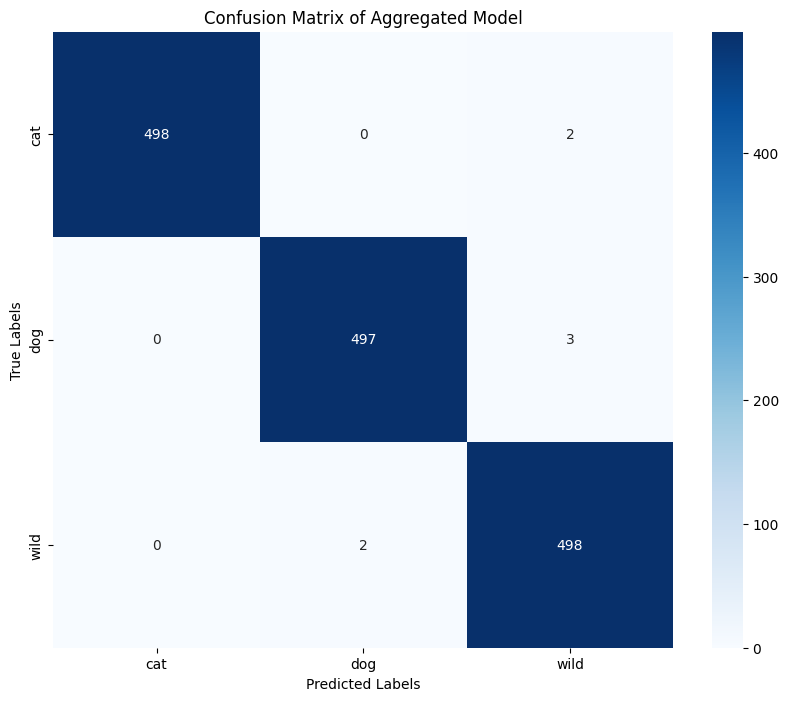

In [64]:
evaluate_aggregated_model(results, classes)